# Experiment 4.1.3: Comparison of Separation Radius

This notebook compares the separation radius of different point sets:
- **Korobov lattices** (our method 1) - using optimal generators from Table korobov_optimal_a
- **Explicit rank-1 lattices** (our method 2) - using p=2
- **Random points** (baseline)
- **Halton sequences** (standard QMC)
- **Sobol sequences** (standard QMC)

**Observation:** Our proposed point sets exhibit separation radius decay of order $N^{-1/d}$, which is optimal for quasi-uniform point sets.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import from lattice_qmc package
from lattice_qmc import KorobovLattice, ExplicitRank1Lattice
from lattice_qmc.utils import generate_primes, compute_separation_radius_fast

# QMCPy for Halton and Sobol
try:
    import qmcpy as qp
    QMCPY_AVAILABLE = True
    print("QMCPy loaded successfully.")
except ImportError:
    QMCPY_AVAILABLE = False
    print("QMCPy not available. Install with: pip install qmcpy")

# Publication-quality plot settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.figsize': (10, 7),
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

np.random.seed(42)
print("Setup complete!")

QMCPy loaded successfully.
Setup complete!


## Helper Functions for Other Point Sets

In [11]:
def generate_random_points(n: int, d: int, seed: int = None) -> np.ndarray:
    """Generate n random points in [0, 1)^d."""
    if seed is not None:
        np.random.seed(seed)
    return np.random.rand(n, d)


def generate_halton_points(n: int, d: int) -> np.ndarray:
    """Generate n Halton sequence points in [0, 1)^d using QMCPy."""
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy is required for Halton sequences.")
    halton = qp.Halton(d, seed=42)
    return halton.gen_samples(n)


def generate_sobol_points(n: int, d: int) -> np.ndarray:
    """Generate n Sobol sequence points in [0, 1)^d using QMCPy."""
    if not QMCPY_AVAILABLE:
        raise ImportError("QMCPy is required for Sobol sequences.")
    sobol = qp.Sobol(d, seed=42)
    return sobol.gen_samples(n)


print("Helper functions loaded.")

Helper functions loaded.


---

## Experiment: Separation Radius Comparison

The separation radius is defined as:
$$q(P) = \frac{1}{2} \min_{i \neq j} \|x_i - x_j\|$$

For quasi-uniform point sets, we expect:
$$q(P) \sim N^{-1/d}$$

This means on a log-log plot of $q$ vs $N$, quasi-uniform point sets should show a slope of $-1/d$.

### Test Configurations

In [15]:
# Load optimal Korobov parameters from previous experiment
try:
    korobov_params = np.load('data/korobov_optimal_parameters.npy', allow_pickle=True).item()
    korobov_primes = korobov_params['primes']
    optimal_generators = korobov_params['optimal_generators']
    print("Loaded optimal Korobov parameters from file.")
    print(f"Using primes: {korobov_primes}")
except FileNotFoundError:
    print("Warning: Could not load optimal parameters. Using default primes.")
    korobov_primes = [3, 7, 13, 31, 61, 127, 251, 509, 1021, 2039, 4093, 8191, 16381, 32749, 65521]
    optimal_generators = None

# Test dimensions
test_dimensions = [2, 3, 5, 7]

# Sobol,halton,random: powers of 2
powers = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Explicit: m parameter (varies by dimension)
# We'll use m large enough to get comparable N values
explicit_m_by_d = {2: 7, 3: 12, 5: 10, 7: 5}
print("\nTest configurations defined.")
print(f"Dimensions: {test_dimensions}")
print(f"Korobov primes (first 9): {korobov_primes[:9]}")
print(f"Explicit m by dimension: {explicit_m_by_d}")

Loaded optimal Korobov parameters from file.
Using primes: [   3    7   13   31   61  127  251  509 1021 2039 4093 8191]

Test configurations defined.
Dimensions: [2, 3, 5, 7]
Korobov primes (first 8): [  3   7  13  31  61 127 251 509]
Explicit m by dimension: {2: 7, 3: 12, 5: 10, 7: 6}


### Compute Separation Radii

In [17]:
def run_separation_radius_experiment(d: int, verbose: bool = True):
    """
    Compute separation radii for all point set types in dimension d.
    Uses optimal Korobov generators when available.
    """
    results = {
        'korobov': {'N': [], 'sep_radius': []},
        'explicit': {'N': [], 'sep_radius': [], 'm': []},
        'random': {'N': [], 'sep_radius': []},
        'halton': {'N': [], 'sep_radius': []},
        'sobol': {'N': [], 'sep_radius': []},
    }
    
    # Get explicit_m for this dimension
    explicit_m = explicit_m_by_d.get(d, 12)
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Dimension d = {d} (explicit_m = {explicit_m})")
        print(f"{'='*60}")
    
    # Korobov lattices - use optimal generators
    if verbose:
        print("\nKorobov lattices (using optimal generators):")
    # Use first 9 primes for manageable computation
    for idx, N in enumerate(korobov_primes[:9]):
        if optimal_generators is not None:
            a_star = optimal_generators[d][idx]
            lattice = KorobovLattice(d=d, N=N, generator=a_star, verbose=False)
        else:
            lattice = KorobovLattice(d=d, N=N, criterion="product", verbose=False)
        
        sep_rad = lattice.separation_radius()
        results['korobov']['N'].append(N)
        results['korobov']['sep_radius'].append(sep_rad)
        if verbose:
            gen_info = f"a*={a_star}" if optimal_generators else "optimized"
            print(f"  N = {N} ({gen_info}): q = {sep_rad:.6f}")
    
    # Explicit rank-1 lattices with p=2
    if verbose:
        print("\nExplicit rank-1 lattices (p=2):")
    p = 2
    alpha = np.array([p**(j/(d+1)) for j in range(1, d+1)])
    for i in range(explicit_m + 1):
        lattice = ExplicitRank1Lattice(d=d, m=i, alpha=alpha, verbose=False)
        Q = lattice.Q
        if Q < 3:  # Skip very small Q
            continue
        sep_rad = lattice.separation_radius()
        results['explicit']['N'].append(Q)
        results['explicit']['sep_radius'].append(sep_rad)
        results['explicit']['m'].append(i)
        if verbose:
            print(f"  m = {i}: Q = {Q}, q = {sep_rad:.6f}")
    
    # Random points
    if verbose:
        print("\nRandom points:")
    for n in powers:
        points = generate_random_points(n, d, seed=42)
        sep_rad = compute_separation_radius_fast(points, toroidal=True)
        results['random']['N'].append(n)
        results['random']['sep_radius'].append(sep_rad)
        if verbose:
            print(f"  N = {n}: q = {sep_rad:.6f}")
    
    # Halton and Sobol sequences
    if QMCPY_AVAILABLE:
        if verbose:
            print("\nHalton sequence:")
        for n in powers:
            points = generate_halton_points(n, d)
            sep_rad = compute_separation_radius_fast(points, toroidal=True)
            results['halton']['N'].append(n)
            results['halton']['sep_radius'].append(sep_rad)
            if verbose:
                print(f"  N = {n}: q = {sep_rad:.6f}")
        
        if verbose:
            print("\nSobol sequence:")
        for n in powers:
            points = generate_sobol_points(n, d)
            sep_rad = compute_separation_radius_fast(points, toroidal=True)
            results['sobol']['N'].append(n)
            results['sobol']['sep_radius'].append(sep_rad)
            if verbose:
                print(f"  N = {n}: q = {sep_rad:.6f}")
    
    return results

In [18]:
# Run experiments for all dimensions
all_results = {}
for d in test_dimensions:
    all_results[d] = run_separation_radius_experiment(d, verbose=True)


Dimension d = 2 (explicit_m = 7)

Korobov lattices (using optimal generators):
  N = 3 (a*=1): q = 0.235702
  N = 7 (a*=3): q = 0.159719
  N = 13 (a*=8): q = 0.138675
  N = 31 (a*=12): q = 0.086857
  N = 61 (a*=53): q = 0.066084
  N = 127 (a*=115): q = 0.047408
  N = 251 (a*=177): q = 0.032672
  N = 509 (a*=376): q = 0.022932
  N = 1021 (a*=798): q = 0.016279
  N = 2039 (a*=1062): q = 0.011742

Explicit rank-1 lattices (p=2):
  m = 1: Q = 3, q = 0.235702
  m = 2: Q = 7, q = 0.159719
  m = 3: Q = 12, q = 0.131762
  m = 4: Q = 46, q = 0.068745
  m = 5: Q = 177, q = 0.026650
  m = 6: Q = 681, q = 0.017758
  m = 7: Q = 858, q = 0.014095

Random points:
  N = 3: q = 0.149910
  N = 7: q = 0.055152
  N = 13: q = 0.018823
  N = 31: q = 0.004409
  N = 61: q = 0.004409
  N = 127: q = 0.001337
  N = 251: q = 0.001337

Halton sequence:
  N = 3: q = 0.174929
  N = 7: q = 0.129568
  N = 13: q = 0.068454
  N = 31: q = 0.030513
  N = 61: q = 0.027830
  N = 127: q = 0.005868
  N = 251: q = 0.004127

S

### Plot Results

Figure saved as 'separation_radius_d2.pdf' and 'separation_radius_d2.png'


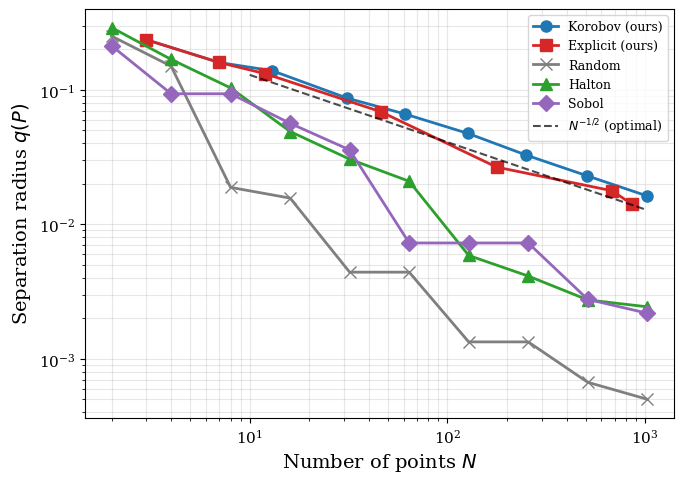

Figure saved as 'separation_radius_d3.pdf' and 'separation_radius_d3.png'


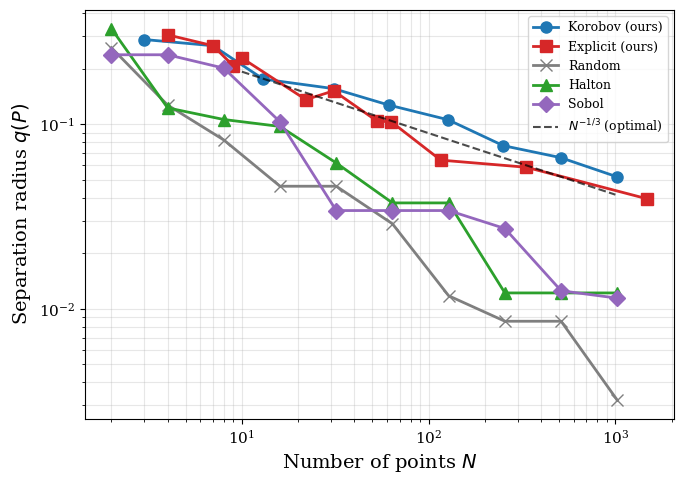

Figure saved as 'separation_radius_d5.pdf' and 'separation_radius_d5.png'


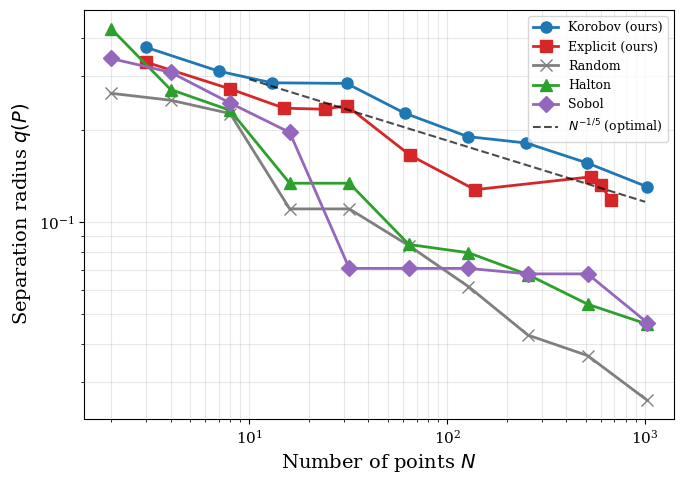

Figure saved as 'separation_radius_d7.pdf' and 'separation_radius_d7.png'


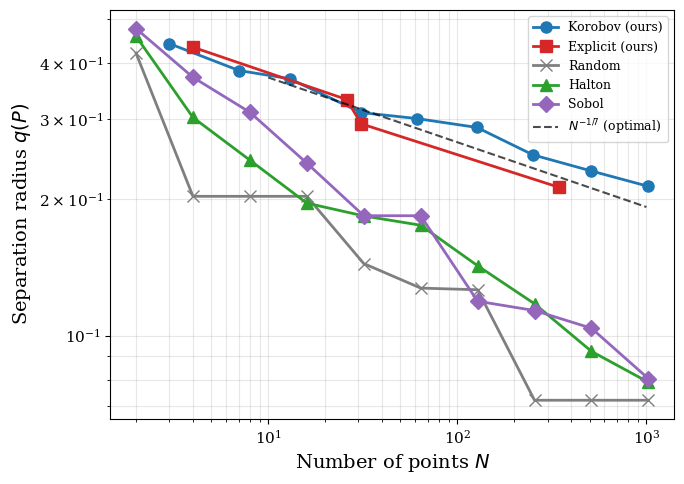

In [43]:
def plot_separation_radius_comparison(all_results: dict, save_fig: bool = True):
    """
    Plot separation radius vs N for each dimension separately.
    """
    styles = {
        'korobov': {'color': '#1f77b4', 'marker': 'o', 'label': 'Korobov (ours)'},
        'explicit': {'color': '#d62728', 'marker': 's', 'label': 'Explicit (ours)'},
        'random': {'color': '#7f7f7f', 'marker': 'x', 'label': 'Random'},
        'halton': {'color': '#2ca02c', 'marker': '^', 'label': 'Halton'},
        'sobol': {'color': '#9467bd', 'marker': 'D', 'label': 'Sobol'},
    }
    for d, results in all_results.items():
        plt.figure(figsize=(7, 5))
        for method, style in styles.items():
            if results[method]['N']:
                plt.loglog(results[method]['N'], results[method]['sep_radius'],
                           marker=style['marker'], color=style['color'],
                           label=style['label'], linewidth=2, markersize=8)
        # Add reference line for N^{-1/d}
        N_ref = np.array([10, 1000])
        scale = results['korobov']['sep_radius'][0] * (results['korobov']['N'][0] ** (1/d))
        q_ref = scale * N_ref ** (-1/d)
        plt.loglog(N_ref, q_ref, 'k--', linewidth=1.5, alpha=0.7,
                   label=f'$N^{{-1/{d}}}$ (optimal)')
        plt.xlabel('Number of points $N$')
        plt.ylabel('Separation radius $q(P)$')
        # plt.title(f'Separation Radius (d = {d})')
        plt.legend(loc='upper right', fontsize=9)
        plt.grid(True, alpha=0.3, which='both')
        plt.tight_layout()
        if save_fig:
            plt.savefig(f'separation_radius_d{d}.pdf')
            plt.savefig(f'separation_radius_d{d}.png', dpi=300)
            print(f"Figure saved as 'separation_radius_d{d}.pdf' and 'separation_radius_d{d}.png'")
        plt.show()

plot_separation_radius_comparison(all_results)

### Compute and Compare Decay Rates

In [44]:
def compute_decay_rate(N_vals, sep_radius_vals):
    """
    Estimate the decay rate by fitting log(q) = a + b*log(N).
    Returns b (the decay exponent).
    """
    if len(N_vals) < 2:
        return np.nan
    log_N = np.log(np.array(N_vals))
    log_q = np.log(np.array(sep_radius_vals))
    coeffs = np.polyfit(log_N, log_q, 1)
    return coeffs[0]


print("\n" + "="*80)
print("DECAY RATE ANALYSIS")
print("Expected: -1/d for quasi-uniform point sets")
print("="*80)

for d in test_dimensions:
    results = all_results[d]
    expected_rate = -1/d
    
    print(f"\nDimension d = {d} (expected rate: {expected_rate:.4f})")
    print("-" * 50)
    
    for method in ['korobov', 'explicit', 'random', 'halton', 'sobol']:
        if results[method]['N']:
            rate = compute_decay_rate(results[method]['N'], results[method]['sep_radius'])
            deviation = abs(rate - expected_rate)
            match = "✓" if deviation < 0.1 else "✗"
            print(f"  {method:10s}: rate = {rate:+.4f}  (deviation: {deviation:.4f}) {match}")


DECAY RATE ANALYSIS
Expected: -1/d for quasi-uniform point sets

Dimension d = 2 (expected rate: -0.5000)
--------------------------------------------------
  korobov   : rate = -0.4597  (deviation: 0.0403) ✓
  explicit  : rate = -0.5023  (deviation: 0.0023) ✓
  random    : rate = -1.0006  (deviation: 0.5006) ✗
  halton    : rate = -0.8279  (deviation: 0.3279) ✗
  sobol     : rate = -0.7550  (deviation: 0.2550) ✗

Dimension d = 3 (expected rate: -0.3333)
--------------------------------------------------
  korobov   : rate = -0.3002  (deviation: 0.0331) ✓
  explicit  : rate = -0.3672  (deviation: 0.0338) ✓
  random    : rate = -0.6504  (deviation: 0.3170) ✗
  halton    : rate = -0.5251  (deviation: 0.1917) ✗
  sobol     : rate = -0.5359  (deviation: 0.2026) ✗

Dimension d = 5 (expected rate: -0.2000)
--------------------------------------------------
  korobov   : rate = -0.1736  (deviation: 0.0264) ✓
  explicit  : rate = -0.1837  (deviation: 0.0163) ✓
  random    : rate = -0.3897  (d